In [ ]:
import pandas as pd
import numpy as np
from nltk import word_tokenize
from collections import Counter

from nltk.corpus import stopwords

import nltk

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import make_scorer, precision_score, f1_score, recall_score

import matplotlib.pyplot as plt

import pdfminer #used PDF package

import string

import spacy

import random

from sklearn.naive_bayes import MultinomialNB

import seaborn as sns

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Jullen18/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## **Trying out Pdfminer and pre-processing data**

In [ ]:
pdfminer.__version__ #confirming latest version, per https://stackoverflow.com/questions/25665/python-module-for-converting-pdf-to-text and https://pypi.org/project/pdfminer/

'20191125'

In [ ]:
#testing out pdfminer, code from https://stackoverflow.com/questions/25665/python-module-for-converting-pdf-to-text

import sys
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import XMLConverter, HTMLConverter, TextConverter
from pdfminer.layout import LAParams
import io

def pdfparser(data):

    fp = open(data, 'rb')
    rsrcmgr = PDFResourceManager()
    retstr = io.StringIO()
    #codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    # Create a PDF interpreter object.
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    # Process each page contained in the document.

    for page in PDFPage.get_pages(fp):
        interpreter.process_page(page)
        data =  retstr.getvalue()

    return(data) #changed this to return data instead

#if __name__ == '__main__':
#    pdfparser(sys.argv[1])

In [ ]:
pdf_list = ["nss2002.pdf", "The National Security Strategy-- 2006.pdf", "NSS2010.pdf", "NSS2015.pdf", "NSS2017.pdf", "Biden-Harris Administration's National Security Strategy 2022.pdf"]
text_list = []

for i in pdf_list:
    text_list.append(pdfparser(i))

In [ ]:
nss_df = pd.DataFrame(data={"file_name": pdf_list, "text":text_list})

In [ ]:
#getting a sense of size of documents:
for i in range(len(nss_df["text"])):
    print(nss_df["file_name"].iloc[i] + " | number of characters: " + str(len(nss_df["text"].iloc[i])))

nss2002.pdf | number of characters: 84646
The National Security Strategy-- 2006.pdf | number of characters: 134565
NSS2010.pdf | number of characters: 188938
NSS2015.pdf | number of characters: 104621
NSS2017.pdf | number of characters: 169715
Biden-Harris Administration's National Security Strategy 2022.pdf | number of characters: 162507


In [ ]:
nss_df["year"]=nss_df["file_name"]
nss_df["year"] = nss_df["year"].str[-8:-4] #learned about string slice method here: https://stackoverflow.com/questions/48773767/how-to-slice-column-values-in-python-pandas-dataframe

In [ ]:
text_tokenized = []
for i in nss_df["text"]:
    text_tokenized.append(word_tokenize(i))

In [ ]:
nss_df["text_tokenized"]=text_tokenized

In [ ]:
text_tokenized_stopwords = []
for i in nss_df["text_tokenized"]:
    for j in i:
        if j in stopwords.words("english"):
            i.remove(j)
    text_tokenized_stopwords.append(i)


In [ ]:
nss_df["text_tokenized_stopwords"]= text_tokenized_stopwords

In [ ]:
#using string lists of alphanumeric characters to further limit tokens, suggested at: https://stackoverflow.com/questions/51265716/is-there-a-list-of-all-alphanumeric-signs-in-python
print(string.ascii_lowercase)
print(string.ascii_uppercase)
print(string.digits)
checker = string.ascii_uppercase + string.ascii_lowercase  + string.digits
print(checker)

abcdefghijklmnopqrstuvwxyz
ABCDEFGHIJKLMNOPQRSTUVWXYZ
0123456789
ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789


In [ ]:
#only including alphanumerical characters and lowercase

text_tokenized_stopwords_alphanumerical = []
for i in nss_df["text_tokenized_stopwords"]: #removing non-alphanumerical characters
    for j in i:
        for k in j:
            if k not in checker:
                i.remove(j)
                break
    text_tokenized_stopwords_alphanumerical.append(i)

for i in text_tokenized_stopwords_alphanumerical: #making everything lowercase
    for j in range(len(i)):
        i[j] = i[j].lower()



In [ ]:
nss_df["text_tokenized_stopwords_alphanumerical"]= text_tokenized_stopwords_alphanumerical

In [ ]:
nss_df.head()

,file_name,text,year,text_tokenized,text_tokenized_stopwords,text_tokenized_stopwords_alphanumerical
0,nss2002.pdf,The National\n\nSecurity Strategy\n\nof the \n...,2002,"[the, national, security, strategy, united, st...","[the, national, security, strategy, united, st...","[the, national, security, strategy, united, st..."
1,The National Security Strategy-- 2006.pdf,\n\n \n\n \n\n \n\nTABLE OF CONTENTS \n\nO...,2006,"[table, of, contents, overview, america, natio...","[table, of, contents, overview, america, natio...","[table, of, contents, overview, america, natio..."
2,NSS2010.pdf,NAT IONA L SECU R IT Y \n\nSTR ATEGY\n\nMay 2...,2010,"[nat, iona, l, secu, r, it, y, str, ategy, may...","[nat, iona, l, secu, r, it, y, str, ategy, may...","[nat, iona, l, secu, r, it, y, str, ategy, may..."
3,NSS2015.pdf,NATIONAL SECURITY \n\nSTRATEGY\n\nF EBRUA RY ...,2015,"[national, security, strategy, f, ebrua, ry, 2...","[national, security, strategy, f, ebrua, ry, 2...","[national, security, strategy, f, ebrua, ry, 2..."
4,NSS2017.pdf,N������� S������� \n\nS�������\n\nof the Unite...,2017,"[united, states, america, d, e, c, e, m, b, e,...","[united, states, america, d, e, c, e, m, b, e,...","[united, states, america, d, e, c, e, m, b, e,..."


In [ ]:
#checking random locations
for i in nss_df["text_tokenized_stopwords_alphanumerical"]:
    index_area = random.randint(0,len(i))
    print(i[index_area-20:index_area+20])


['inter-american', 'development', 'bank', 'president', 'bush', 'march', '14', '2002', 'a', 'world', 'some', 'live', 'comfort', 'this', 'administration', 'goal', 'help', 'unleash', 'plenty', 'half', 'the', 'human', 'race', 'lives', 'less', '2', 'a', 'day', 'neither', 'just', 'nor', 'stable', 'including', 'all', 'the', 'world', 'poor', 'an', 'expanding', 'circle']
['they', 'pursue', 'wmd', 'their', 'peril', '_____________________________________________________________________________________________________________________', 'national', 'security', 'strategy', '24', 'vi', 'ignite', 'a', 'new', 'era', 'global', 'economic', 'growth', 'free', 'markets', 'free', 'trade', 'a', 'summary', 'national', 'security', 'strategy', '2002', 'promoting', 'free', 'fair', 'trade', 'long', 'been', 'a', 'bedrock', 'tenet', 'american', 'foreign', 'policy']
['nonstate', 'actors', 'corporations', 'foundations', 'nongovern-', 'mental', 'organizations', 'universities', 'think', 'tanks', 'faith-based', 'organiza

## **Dictionary-based Methods**

In [ ]:
#let's begin by looking at one document and then expanding

nss_2022_tokenized = nss_df["text_tokenized_stopwords_alphanumerical"].iloc[5]

nss_2022_counter = Counter()

for token in nss_2022_tokenized:
    nss_2022_counter[token] += 1

In [ ]:
print(len(nss_2022_counter))
print(nss_2022_counter["china"])
print(nss_2022_counter["russia"])
print(nss_2022_counter["ukraine"])
print(nss_2022_counter["assertive"]) #probably not the best NSS for this, then, let's try Trump's 2017 NSS



3170
9
58
32
1


In [ ]:
nss_2017_tokenized = nss_df["text_tokenized_stopwords_alphanumerical"].iloc[4]

nss_2017_counter = Counter()

for token in nss_2017_tokenized:
    nss_2017_counter[token] += 1


print(len(nss_2017_counter))
print(nss_2017_counter["china"])
print(nss_2017_counter["russia"])
print(nss_2017_counter["ukraine"])
print(nss_2017_counter["assertive"]) #hmm, China is definitely more important, but "assertive" is not as prominent
#probably representing the idea the idea of "language slippage" here

3708
33
22
1
0


In [ ]:
#let's do this for all of them
nss_token_dict = {}
for i in range(len(nss_df["text_tokenized_stopwords_alphanumerical"])):
    temp_counter = Counter()
    temp_tokenized = nss_df["text_tokenized_stopwords_alphanumerical"].iloc[i]
    for token in temp_tokenized:
        temp_counter[token] += 1
    nss_token_dict[str(nss_df["year"].iloc[i])] = temp_counter #inspired by https://stackoverflow.com/questions/1060090/changing-variable-names-with-python-for-loops





In [ ]:
for i in nss_token_dict.keys():
    print ("Year: " + str(i))
    print("'china' count: " + str(nss_token_dict[i]["china"]))
    print("'russia' count: " + str(nss_token_dict[i]["russia"]))
    print("'ukraine' count: " + str(nss_token_dict[i]["ukraine"]))
    print("'assertive' count: " + str(nss_token_dict[i]["assertive"]))
    print("--------------------")
    print("")

Year: 2002
'china' count: 18
'russia' count: 14
'ukraine' count: 0
'assertive' count: 0
--------------------

Year: 2006
'china' count: 28
'russia' count: 16
'ukraine' count: 3
'assertive' count: 0
--------------------

Year: 2010
'china' count: 10
'russia' count: 12
'ukraine' count: 0
'assertive' count: 0
--------------------

Year: 2015
'china' count: 12
'russia' count: 8
'ukraine' count: 5
'assertive' count: 1
--------------------

Year: 2017
'china' count: 33
'russia' count: 22
'ukraine' count: 1
'assertive' count: 0
--------------------

Year: 2022
'china' count: 9
'russia' count: 58
'ukraine' count: 32
'assertive' count: 1
--------------------



In [ ]:
def word_stats(data, stopwords=None, n=20): ##function is from class
    type(stopwords)
    if stopwords is not None:
        for stop in stopwords:
            del data[stop]
    count_sum = 0
    for token in data:
        count_sum += data[token]
    print("Total words in the text: " + str(count_sum))
    print("")
    print("Top " + str(n) + " words by frequency:")
    most_common = data.most_common()[:n]
    for i in most_common:
        print(i)

In [ ]:
# helper function to apply function to dict

def apply_to_dict(function, dict_to_use=nss_token_dict):
    for i in dict_to_use.keys():
        print(i)
        function(dict_to_use[i])
        print("")

In [ ]:
apply_to_dict(word_stats)

2002
Total words in the text: 8932

Top 20 words by frequency:
('the', 418)
('our', 123)
('states', 118)
('we', 108)
('united', 88)
('a', 74)
('•', 71)
('security', 70)
('must', 61)
('national', 60)
('world', 58)
('strategy', 50)
('trade', 49)
('to', 44)
('global', 44)
('new', 44)
('freedom', 42)
('america', 41)
('in', 39)
('economic', 39)

2006
Total words in the text: 13216

Top 20 words by frequency:
('the', 623)
('•', 175)
('a', 151)
('states', 141)
('security', 130)
('united', 108)
('we', 98)
('national', 96)
('strategy', 85)
('our', 79)
('must', 70)
('world', 69)
('in', 69)
('international', 69)
('freedom', 69)
('economic', 64)
('people', 62)
('new', 61)
('challenges', 59)
('nations', 59)

2010
Total words in the text: 19144

Top 20 words by frequency:
('the', 708)
('our', 353)
('.', 349)
('we', 281)
('security', 273)
('a', 193)
('international', 189)
('states', 155)
('global', 151)
('united', 143)
('must', 128)
('world', 121)
('national', 115)
('to', 110)
('will', 102)
('people'

### Vectorization and Sentiment Analysis

In [ ]:
#create string from text_tokenized_stopwords_alphanumerical

text_tokenized_stopwords_alphanumerical_strings = []

for i in nss_df["text_tokenized_stopwords_alphanumerical"]:
    text_tokenized_stopwords_alphanumerical_strings.append(" ".join(i))


nss_df["text_tokenized_stopwords_alphanumerical_strings"] = text_tokenized_stopwords_alphanumerical_strings
nss_df.head()

,file_name,text,year,text_tokenized,text_tokenized_stopwords,text_tokenized_stopwords_alphanumerical,text_tokenized_stopwords_alphanumerical_strings
0,nss2002.pdf,The National\n\nSecurity Strategy\n\nof the \n...,2002,"[the, national, security, strategy, united, st...","[the, national, security, strategy, united, st...","[the, national, security, strategy, united, st...",the national security strategy united states a...
1,The National Security Strategy-- 2006.pdf,\n\n \n\n \n\n \n\nTABLE OF CONTENTS \n\nO...,2006,"[table, of, contents, overview, america, natio...","[table, of, contents, overview, america, natio...","[table, of, contents, overview, america, natio...",table of contents overview america national se...
2,NSS2010.pdf,NAT IONA L SECU R IT Y \n\nSTR ATEGY\n\nMay 2...,2010,"[nat, iona, l, secu, r, it, y, str, ategy, may...","[nat, iona, l, secu, r, it, y, str, ategy, may...","[nat, iona, l, secu, r, it, y, str, ategy, may...",nat iona l secu r it y str ategy may 2010 tabl...
3,NSS2015.pdf,NATIONAL SECURITY \n\nSTRATEGY\n\nF EBRUA RY ...,2015,"[national, security, strategy, f, ebrua, ry, 2...","[national, security, strategy, f, ebrua, ry, 2...","[national, security, strategy, f, ebrua, ry, 2...",national security strategy f ebrua ry 2 015 th...
4,NSS2017.pdf,N������� S������� \n\nS�������\n\nof the Unite...,2017,"[united, states, america, d, e, c, e, m, b, e,...","[united, states, america, d, e, c, e, m, b, e,...","[united, states, america, d, e, c, e, m, b, e,...",united states america d e c e m b e r 2 0 1 7 ...


In [ ]:
sent_analyzer = SentimentIntensityAnalyzer()


#print(sent_analyzer.polarity_scores(c_docs_text))#["neg"])
for i in range(len(nss_df["text_tokenized_stopwords_alphanumerical_strings"])):
    print(nss_df["year"].iloc[i])
    print(sent_analyzer.polarity_scores(nss_df["text_tokenized_stopwords_alphanumerical_strings"].iloc[i]))
    print("-----------")
    print("")


2002
{'neg': 0.175, 'neu': 0.54, 'pos': 0.285, 'compound': 1.0}
-----------

2006
{'neg': 0.163, 'neu': 0.537, 'pos': 0.3, 'compound': 1.0}
-----------

2010
{'neg': 0.107, 'neu': 0.592, 'pos': 0.301, 'compound': 1.0}
-----------

2015
{'neg': 0.136, 'neu': 0.583, 'pos': 0.281, 'compound': 1.0}
-----------

2017
{'neg': 0.139, 'neu': 0.561, 'pos': 0.3, 'compound': 1.0}
-----------

2022
{'neg': 0.113, 'neu': 0.607, 'pos': 0.28, 'compound': 1.0}
-----------



In [ ]:
assertive_list = ["assertive", "asserts", "threatens", "security", "threat", "revisionist", "taiwan", "china sea"]
assertive_dict = {}

for i in nss_token_dict.keys():
    counter = Counter()
    for j in assertive_list:
        counter[j] = nss_token_dict[i][j]
        assertive_dict[i] = counter

In [ ]:
assertive_dict["2002"] #how to preserve order? for regressions

Counter({'security': 70,
         'threat': 17,
         'taiwan': 4,
         'threatens': 2,
         'assertive': 0,
         'asserts': 0,
         'revisionist': 0,
         'china sea': 0})

In [ ]:
for i in assertive_dict.keys():
    X=[]
    for j in assertive_dict[i]:
        X.append(assertive_dict[i][j])
    X = np.array(X).reshape(1,-1)
    curr_index = nss_df["year"].tolist().index(i)
    y= [sent_analyzer.polarity_scores(nss_df["text_tokenized_stopwords_alphanumerical_strings"].iloc[curr_index])["neg"]]
    log_model = LinearRegression().fit(X=X, y=y)
    print("year: ", i)
    print(log_model.coef_)
    print(log_model.intercept_)


year:  2002
[0. 0. 0. 0. 0. 0. 0. 0.]
0.175
year:  2006
[0. 0. 0. 0. 0. 0. 0. 0.]
0.163
year:  2010
[0. 0. 0. 0. 0. 0. 0. 0.]
0.107
year:  2015
[0. 0. 0. 0. 0. 0. 0. 0.]
0.136
year:  2017
[0. 0. 0. 0. 0. 0. 0. 0.]
0.139
year:  2022
[0. 0. 0. 0. 0. 0. 0. 0.]
0.113


## Word Embeddings

In [ ]:
sp_model = spacy.load("en_core_web_lg")

In [ ]:
def get_doc_embedding(input_str, spacy_obj=sp_model):
    text_loaded = spacy_obj(input_str)
    word_embedding_vector = []
    curr_vector = []

    for i in text_loaded:
        if (i.is_stop or i.is_punct or i.is_space) == False and i.has_vector == True:
            curr_vector = i.vector
            word_embedding_vector.append(curr_vector)

    return_vector = np.mean(word_embedding_vector, axis=0)
    return(return_vector)

In [ ]:
embedding_vector= np.zeros((6, 300))

for i in range(len( nss_df["text_tokenized_stopwords_alphanumerical_strings"])):
    embedding_vector[i] = get_doc_embedding(nss_df["text_tokenized_stopwords_alphanumerical_strings"].iloc[i])

In [ ]:
##embedding_vector = np.einsum("ij->ji", embedding_vector) #https://stackoverflow.com/questions/23943379/swapping-the-dimensions-of-a-numpy-array
print(embedding_vector.shape)

(6, 300)


In [ ]:
y_sentiment_score = []
for i in range(len(nss_df["text_tokenized_stopwords_alphanumerical_strings"])):
    y_sentiment_score.append(sent_analyzer.polarity_scores(nss_df["text_tokenized_stopwords_alphanumerical_strings"].iloc[i])["neg"])
y_sentiment_score = np.array(y_sentiment_score)
print(y_sentiment_score)


#np.mean(cross_val_score(LogisticRegression(), embedding_vector, np.array(nss_df["year"]), cv=2, scoring="accuracy"))

[0.175 0.163 0.107 0.136 0.139 0.113]


In [ ]:
np.array(nss_df["year"])

array(['2002', '2006', '2010', '2015', '2017', '2022'], dtype=object)

In [ ]:
# Saving nss_df to CSV to work on BERT-based embeddings, will continue work below at a later stage

nss_df.to_csv("nss.csv")

In [ ]:
## reducing dimensionality for plotting
embeddings_trunc = []
svd = TruncatedSVD()
for i in embedding_vector:
    arr_i = np.array(i)
    to_input = arr_i.reshape(1,-1)
    embeddings_trunc[i] = svd.fit_transform(to_input)

/Users/Jullen18/opt/anaconda3/envs/3350/lib/python3.11/site-packages/sklearn/decomposition/_truncated_svd.py:268: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
embeddings_trunc = svd.fit_transform(embedding_vector)

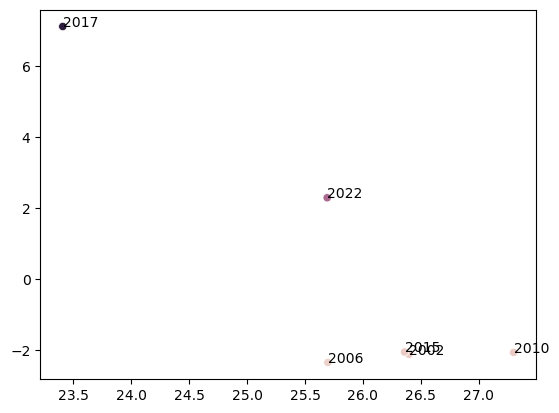

In [ ]:
years = nss_df["year"]
plt = sns.scatterplot(x= embeddings_trunc[:,0], y=embeddings_trunc[:,1], hue=embeddings_trunc[:,1], legend=None)

for i, txt in enumerate(years):
    plt.text(embeddings_trunc[:,0][i], embeddings_trunc[:,1][i], txt) #inspired by: https://python-charts.com/seaborn/texts/

In [ ]:
nss_df["text"].iloc[0][:100]

In [ ]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle') #inspired by: https://stackoverflow.com/questions/4576077/how-can-i-split-a-text-into-sentences
#fp = open("test.txt")
#data = fp.read()
print(tokenizer.tokenize(nss_df["text"].iloc[0][:500]))

In [ ]:
sentence_list = []
for i in nss_df["text"]:
    sentence_list.append(tokenizer.tokenize(i))

In [ ]:
sentence_list[0]

In [ ]:
document_embeddings_by_sentence = []

for i in sentence_list[0]:
    list_to_append = []
    for j in i:
        list_to_append.append(get_doc_embedding(j))
    document_embeddings_by_sentence.append(list_to_append)

In [ ]:
#document_embeddings_by_sentence = []
document_1_embeddings_by_sentence = []

for i in sentence_list[0]:
    document_1_embeddings_by_sentence.append(get_doc_embedding(i))
    document_1_embeddings_by_sentence = [document_1_embeddings_by_sentence]

In [ ]:
trunc_sent_embeddings = svd.fit(document_1_embeddings_by_sentence)